In [1]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [2]:
A0 = 10**(106/20)
wp = 3.8*np.pi*2
A = lambda s: A0/(1+s/wp)
def invA(s, alpha):
    if callable(alpha):
        return -A(s)*alpha(s)/(A(s)+1+alpha(s))
    else:
        return -A(s)*alpha/(A(s)+1+alpha)

In [3]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [4]:
def plot_bode(filename: str, fig = None, axes = None, name=None, argshift=None, legend=False, xlim=None, cutoff_db=-60):
    is_new = False
    if fig is None:
        is_new = True
        fig, axes = plt.subplots(2, 1, figsize=(10, 4))
    df = pd.read_csv(filename, names=["f", "mag", "phase"], skiprows=1)
    if cutoff_db:
        df = df[df["mag"] > 10**(cutoff_db/20)]
    axes[0].plot(df["f"], 20*np.log10(df["mag"]), label=name if name else filename)
    axes[1].plot(df["f"], argshift(df["phase"]) if argshift else df["phase"], label=name if name else filename)
    if is_new:
        axstg1 = AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", legend=legend, grid="both", xlim=xlim)
        axstg1.apply_axes(axes[0])
        axstg2 = AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", legend=legend, grid="both", xlim=xlim)
        axstg2.apply_axes(axes[1])
        fig.tight_layout()
        fig.suptitle(name if name else filename)
    return fig, axes

def plot_bode_spice(filename: str, axes = None, name=None, argshift=None):
    df = pd.read_csv(filename, names=["f", "re", "im"], skiprows=1, sep=r"\t|,", engine="python")
    df["h"] = df["re"] + 1j*df["im"]
    df["mag"] = np.abs(df["h"])
    df["phase"] = np.angle(df["h"], deg=True)
    axes[0].plot(df["f"], 20*np.log10(df["mag"]), label=name if name else filename)
    axes[1].plot(df["f"], argshift(df["phase"]) if argshift else df["phase"], label=name if name else filename)

def plot_osc(filename: str, axes):
    df = pd.read_csv(filename, names=["t1", "v1", "t2", "v2"], skiprows=1, usecols=[0, 1, 3, 4])
    axes.plot(df["t1"], df["v1"], c="blue", label="CH1")
    axes.plot(df["t2"], df["v2"], c="orange", label="CH2")

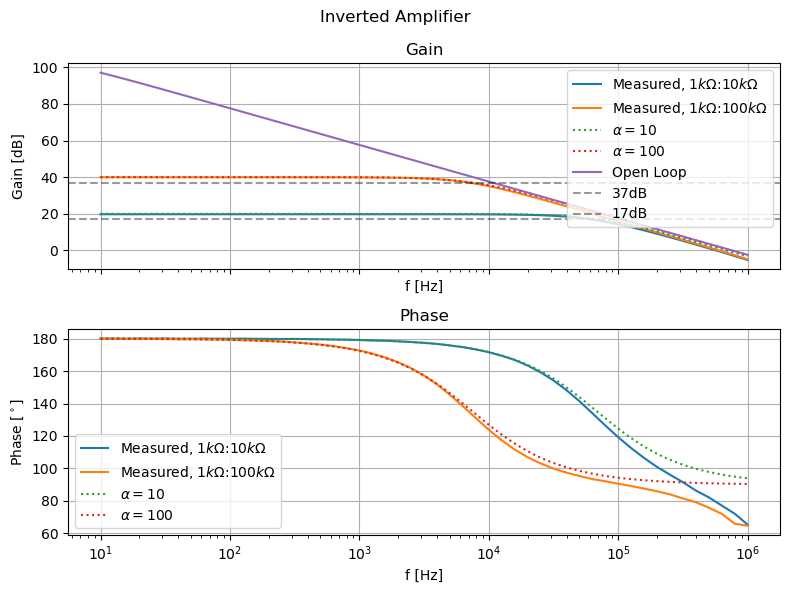

In [5]:
axstgs = [
    AxesSetting(title="Gain", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", grid="both"),
    AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", grid="both")
]
axstgs_osc = AxesSetting(title="Oscilloscope", xlabel="t [s]", ylabel="V [V]", grid="both")
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plot_bode("1_bode_invert_1k_10k.csv", fig, axes, name="Measured, $1k\Omega$:$10k\Omega$", argshift=lambda x: x+360)
plot_bode("1_bode_invert_1k_100k.csv", fig, axes, name="Measured, $1k\Omega$:$100k\Omega$")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(invA(2j*np.pi*f, 10))), label="$\\alpha=10$", xlim=(1e1, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(invA(2j*np.pi*f, 10), deg=True), label="$\\alpha=10$", xlim=(1e1, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(invA(2j*np.pi*f, 100))), label="$\\alpha=100$", xlim=(1e1, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(invA(2j*np.pi*f, 100), deg=True), label="$\\alpha=100$", xlim=(1e1, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open Loop", xlim=(1e1, 1e6))
axes[0].axhline(40-3, color="black", alpha=0.4, linestyle="--", label="37dB")
axes[0].axhline(20-3, color="black", alpha=0.4, linestyle="--", label="17dB")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Inverted Amplifier")
fig.tight_layout()

[4.13914206e-19 7.65784160e-07]


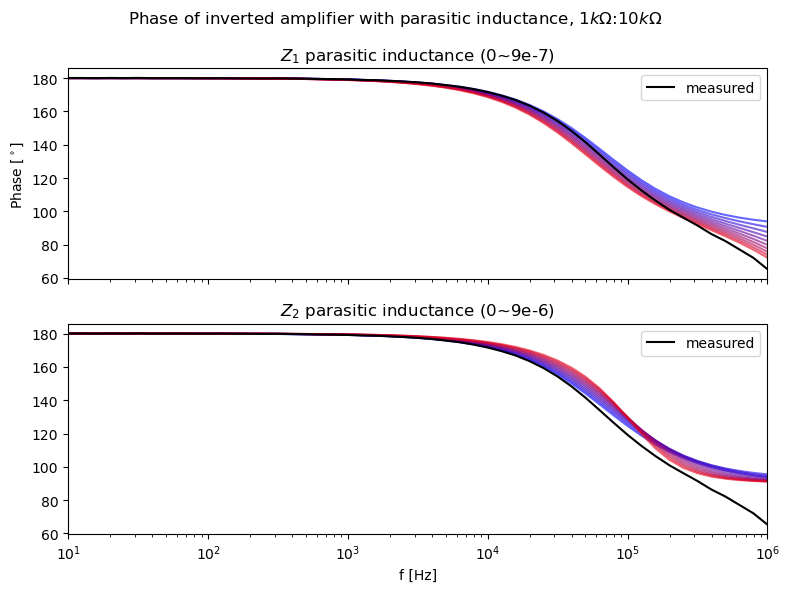

In [6]:
phase_fit_10 = lambda s, a, b: invA(s, (10 + a*s)/(1 + b*s))
phase_fit_100 = lambda s, a, b: invA(s, (100 + a*s)/(1 + b*s))
df_10 = pd.read_csv("1_bode_invert_1k_10k.csv", names=["f", "mag", "phase"], skiprows=1)
df_10 = df_10[df_10["mag"] > 10**(-60/20)]
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
popt, pcov = curve_fit(lambda f, a, b: np.angle(phase_fit_10(2j*np.pi*f, a, b), deg=True), df_10["f"], df_10["phase"]+360, p0=[0, 0], bounds=([0, 0], [0.1, 0.1]))
axes[0].set_xlim(1e1, 1e6)
axes[0].set_xscale("log")
axes[0].plot(df_10["f"], df_10["phase"]+360, label="measured", c="black", zorder=5)
axes[1].plot(df_10["f"], df_10["phase"]+360, label="measured", c="black", zorder=5)
for i in range(10):
    axes[0].plot(df_10["f"], np.angle(phase_fit_10(2j*np.pi*df_10["f"], 0, i*1e-7), deg=True), alpha=0.6, color = colorFader("blue", "red", i/10))
    axes[1].plot(df_10["f"], np.angle(phase_fit_10(2j*np.pi*df_10["f"], i*1e-6, 0), deg=True), alpha=0.6, color = colorFader("blue", "red", i/10))
fig.suptitle("Phase of inverted amplifier with parasitic inductance, $1k\Omega$:$10k\Omega$")
axes[1].set_xlabel("f [Hz]")
axes[0].set_ylabel("Phase [$^\circ$]")
axes[0].set_title("$Z_1$ parasitic inductance (0~9e-7)")
axes[1].set_title("$Z_2$ parasitic inductance (0~9e-6)")
axes[0].legend()
axes[1].legend()
fig.tight_layout()
print(popt)

In [7]:
def noninvA(s, beta):
    if callable(beta):
        return A(s)*beta(s)/(A(s)+beta(s))
    else:
        return A(s)*beta/(A(s)+beta)

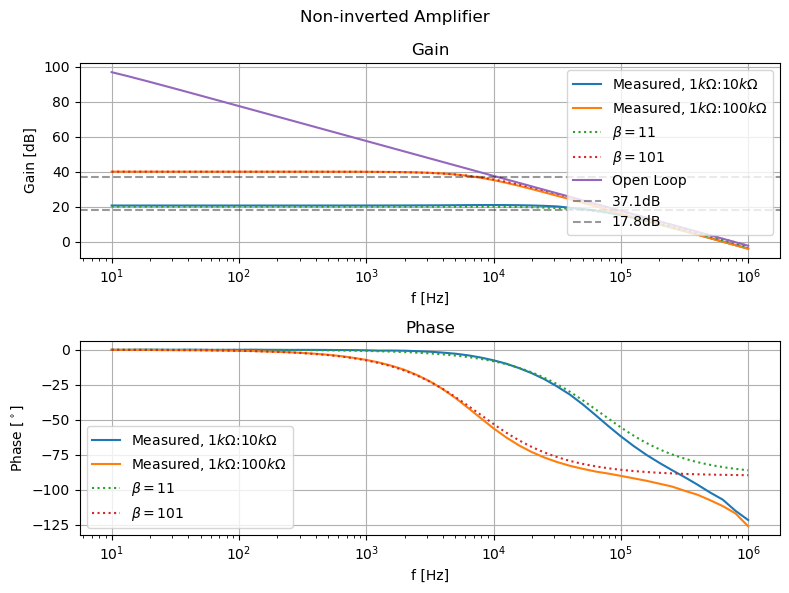

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
plot_bode("1_bode_noinvert_1k_10k.csv", fig, axes, name="Measured, $1k\Omega$:$10k\Omega$")
plot_bode("1_bode_noinvert_1k_100k.csv", fig, axes, name="Measured, $1k\Omega$:$100k\Omega$")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(invA(2j*np.pi*f, 10))), label="$\\beta=11$", xlim=(1e1, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(noninvA(2j*np.pi*f, 11), deg=True), label="$\\beta=11$", xlim=(1e1, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(invA(2j*np.pi*f, 100))), label="$\\beta=101$", xlim=(1e1, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(noninvA(2j*np.pi*f, 101), deg=True), label="$\\beta=101$", xlim=(1e1, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open Loop", xlim=(1e1, 1e6))
axes[0].axhline(20*np.log10(101/np.sqrt(2)), color="black", alpha=0.4, linestyle="--", label=f"{20*np.log10(101/np.sqrt(2)):.1f}dB")
axes[0].axhline(20*np.log10(11/np.sqrt(2)), color="black", alpha=0.4, linestyle="--", label=f"{20*np.log10(11/np.sqrt(2)):.1f}dB")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Non-inverted Amplifier")
fig.tight_layout()

/tmp/ipykernel_6470/1439278160.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

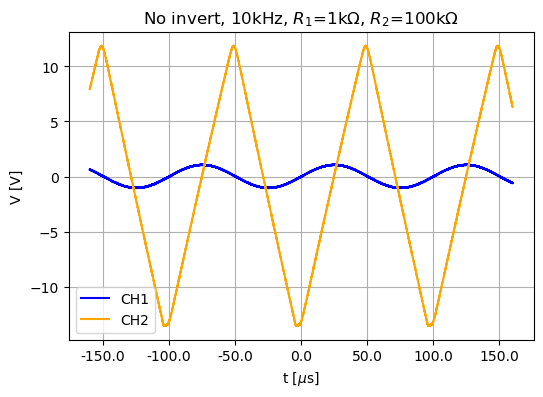

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("1_osc_noinvert_2Vpp_10kHz_1k_100k.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("No invert, 10kHz, $R_1$=1k$\Omega$, $R_2$=100k$\Omega$")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

In [10]:
def A_derv(s, Cf, Rf, Cr, Rr):
    return s*Cr*Rf/(s*Cr*Rr + 1)/(s*Cf*Rf + 1)

Cf = 214e-12
Cr = 218.6e-9
Rr = 9.981e3
Rf = 99.09e3
omega_0 = np.sqrt(wp*(A0+1)/Rf/Cr)
zeta = (np.sqrt(Rf*Cr*wp)+1/np.sqrt(Rf*Cr*wp))/2/np.sqrt(A0+1)
print(zeta)
A_derv_set = lambda s: A_derv(s, Cf, Rf, Cr, Rr)

0.002361483356277997


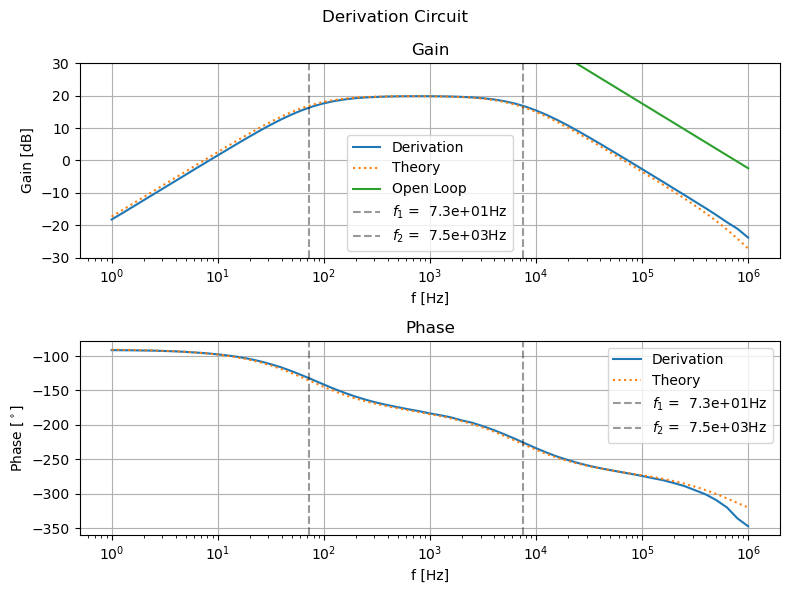

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
plot_bode("2_bode_derv.csv", fig, axes, name="Derivation")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(invA(2j*np.pi*f, A_derv_set))), label="Theory", xlim=(1e0, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(invA(2j*np.pi*f, A_derv_set), deg=True)%360.0-360, label="Theory", xlim=(1e0, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open Loop", xlim=(1e1, 1e6))
axes[0].axvline(1/(2*np.pi*Rr*Cr), color="black", alpha=0.4, linestyle="--", label=f"$f_1$ = {1/(2*np.pi*Rr*Cr): .1e}Hz")
axes[0].axvline(1/(2*np.pi*Rf*Cf), color="black", alpha=0.4, linestyle="--", label=f"$f_2$ = {1/(2*np.pi*Rf*Cf): .1e}Hz")
axes[1].axvline(1/(2*np.pi*Rr*Cr), color="black", alpha=0.4, linestyle="--", label=f"$f_1$ = {1/(2*np.pi*Rr*Cr): .1e}Hz")
axes[1].axvline(1/(2*np.pi*Rf*Cf), color="black", alpha=0.4, linestyle="--", label=f"$f_2$ = {1/(2*np.pi*Rf*Cf): .1e}Hz")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axes[0].set_ylim(-30, 30)
fig.suptitle("Derivation Circuit")
fig.tight_layout()

/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


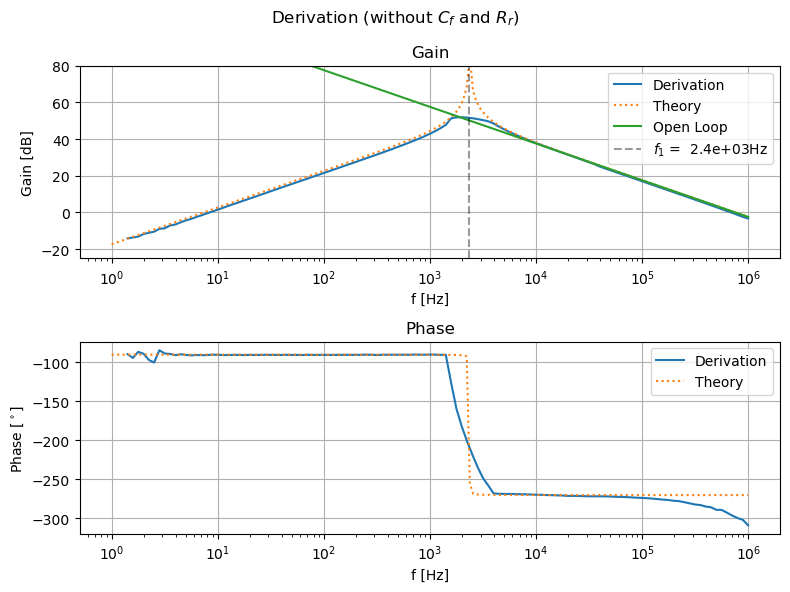

In [16]:
f_derv = lambda s: invA(s, s*Cr*Rf)
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
plot_bode("2_bode_derv_woutf_wider.csv", fig, axes, name="Derivation", cutoff_db=-15)
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(f_derv(2j*np.pi*f)), label="Theory", xlim=(1e0, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(f_derv(2j*np.pi*f), deg=True)%360.0-360, label="Theory", xlim=(1e0, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open Loop", xlim=(1e1, 1e6))
axes[0].axvline(omega_0*np.sqrt(1-2*zeta**2)/2/np.pi, color="black", alpha=0.4, linestyle="--", label=f"$f_1$ = {omega_0*np.sqrt(1-2*zeta**2)/2/np.pi: .1e}Hz")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axes[0].set_ylim(-25, 80)
fig.suptitle("Derivation (without $C_f$ and $R_r$)")
fig.tight_layout()

/tmp/ipykernel_6470/2509734717.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*data["xfactor"]))
/tmp/ipykernel_6470/2509734717.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*data["xfactor"]))
/tmp/ipykernel_6470/2509734717.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*data["xfactor"]))


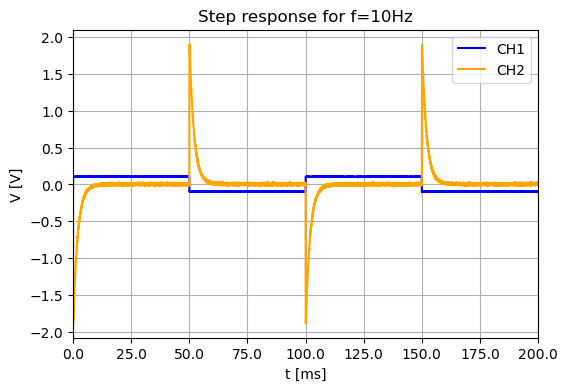

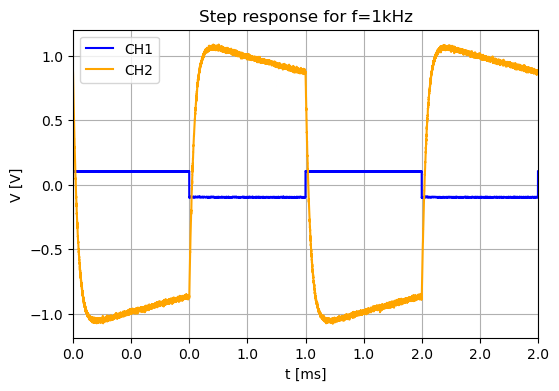

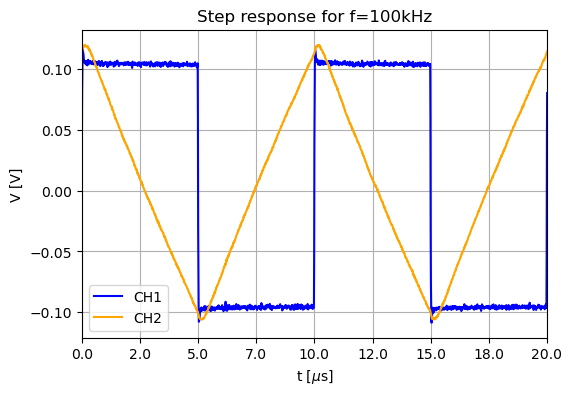

In [24]:
responses = [
    {"name": "2_osc_derv_200mVpp_10Hz.csv", "f": "10Hz", "xlim": (0, 200e-3), "xfactor": 1e3, "xunit": "ms"},
    {"name": "2_osc_derv_200mVpp_1kHz.csv", "f": "1kHz", "xlim": (0, 2e-3), "xfactor": 1e3, "xunit": "ms"},
    {"name": "2_osc_derv_200mVpp_100kHz.csv", "f": "100kHz", "xlim": (0, 2e-5), "xfactor": 1e6, "xunit": "$\mu$s"},
]
for data in responses:
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    plot_osc(data["name"], axes)
    axstgs_osc.apply_axes(axes)
    axes.set_title(f"Step response for f={data['f']}")
    axes.set_xlim(data["xlim"])
    axes.set_xticklabels(np.round(axes.get_xticks()*data["xfactor"]))
    axes.set_xlabel(f"t [{data['xunit']}]")

/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


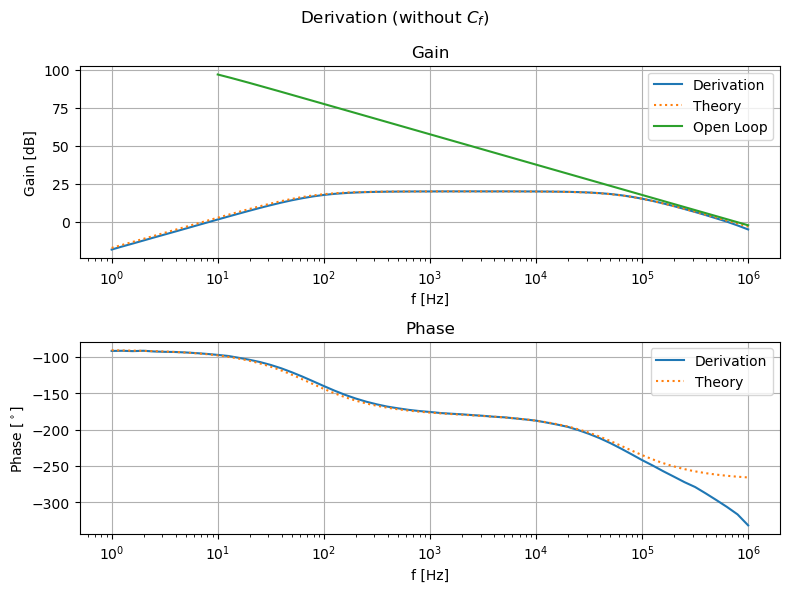

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
f_dervcf = lambda s: invA(s, s*Cr*Rf/(1+s*Cr*Rr))
plot_bode("2_bode_derv_woutcf.csv", fig, axes, name="Derivation")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(f_dervcf(2j*np.pi*f)), label="Theory", xlim=(1e0, 1e6), linestyle=":")
axstgs[1].plot_func(axes[1], lambda f: np.angle(f_dervcf(2j*np.pi*f), deg=True)%360.0-360, label="Theory", xlim=(1e0, 1e6), linestyle=":")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open Loop", xlim=(1e1, 1e6))
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation (without $C_f$)")
fig.tight_layout()

In [83]:
C1 = 24.33e-9
C2 = 21.88e-9
R=10e3
C=22e-9
H_wien = lambda s, k: k*R*C*s/((R*C*s)**2+3*R*C*s+1)

/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/inohaan/usr/src/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/inohaan/usr/src/anaconda3/lib/python3.11

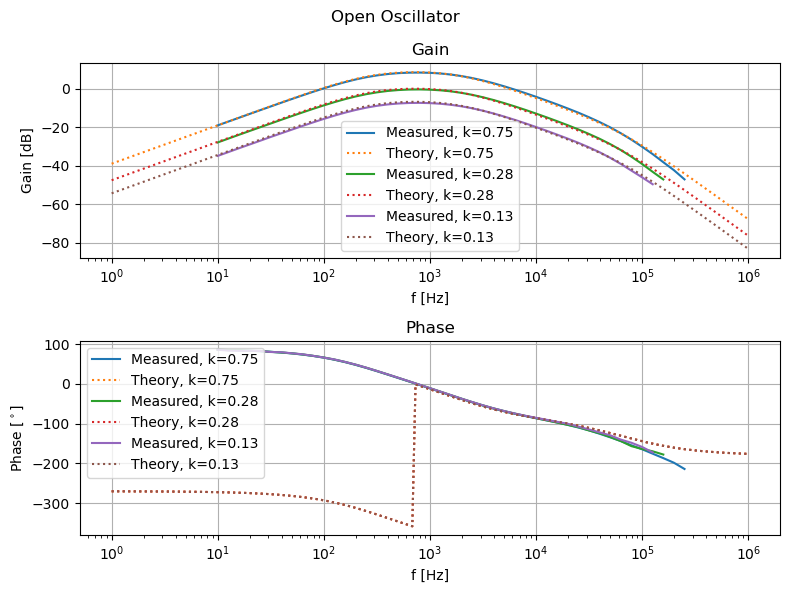

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
files = [
    {"name": "3_bode_7.488.csv", "k": 7.488},
    {"name": "3_bode_2.78.csv", "k": 2.78},
    {"name": "3_bode_1.268.csv", "k": 1.268}
]
for file in files:
    plot_bode(file["name"], fig, axes, name=f"Measured, k={file['k']/10.041:.2f}", cutoff_db=-50)
    axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(H_wien(2j*np.pi*f, file['k']/10.041)*noninvA(2j*np.pi*f, 11)), label=f"Theory, k={file['k']/10.041:.2f}", xlim=(1e0, 1e6), linestyle=":")
    axstgs[1].plot_func(axes[1], lambda f: np.angle(H_wien(2j*np.pi*f, file['k']/10.041)*noninvA(2j*np.pi*f, 11), deg=True)%360.0-360, label=f"Theory, k={file['k']/10.041:.2f}", xlim=(1e0, 1e6), linestyle=":")
# plot_bode("3_bode_7.488.csv", fig, axes, name="7.488")
# plot_bode("3_bode_2.78.csv", fig, axes, name="2.78")
# plot_bode("3_bode_1.268.csv", fig, axes, name="1.268")

axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Open Oscillator")
fig.tight_layout()

/tmp/ipykernel_6470/3795977363.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e3))


Text(0.5, 0, 't [ms]')

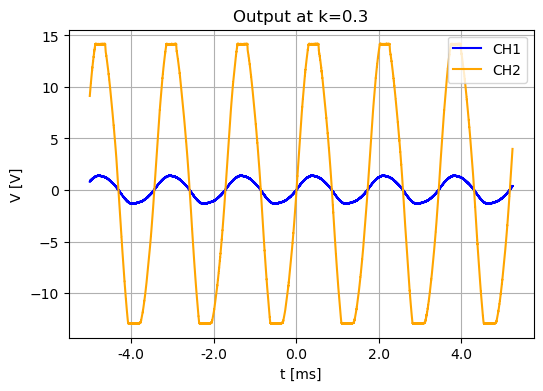

In [81]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("3_osc_edge.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Output at k=0.3")
axes.set_xticklabels(np.round(axes.get_xticks()*1e3))
axes.set_xlabel("t [ms]")

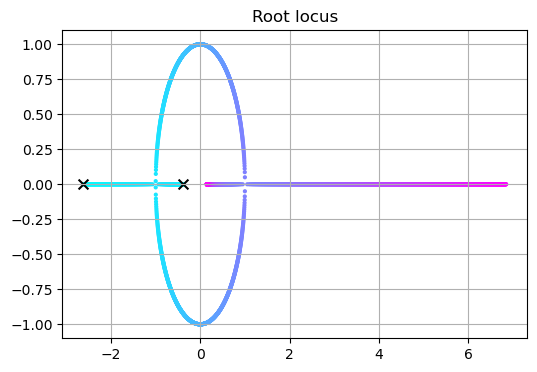

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
rlocus = lambda k, A: [(-3+k*A+np.emath.sqrt((3-k*A)**2-4))/2, (-3+k*A-np.emath.sqrt((3-k*A)**2-4))/2]
k = np.linspace(0, 1, 2000)
rl = rlocus(k, 10)
axes.scatter(np.real(rl[0]), np.imag(rl[0]), c=k, cmap="cool", s=4)
axes.scatter(np.real(rl[1]), np.imag(rl[1]), c=k, cmap="cool", s=4)
axes.scatter([(-3+np.emath.sqrt(5))/2, (-3-np.emath.sqrt(5))/2], [0, 0], marker="x", c="black", s=50, label="Poles")
axes.set_title("Root locus")
axes.grid()

In [ ]:
axstgs_filters = [
    AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", grid="both", ylim=(-60, 5), xlim=(1e0, 1e6)),
    AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", grid="both", xlim=(1e0, 1e6))
]

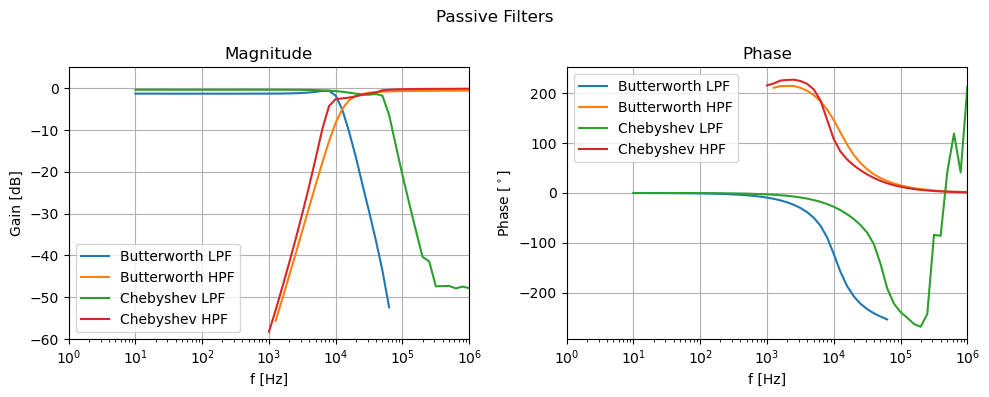

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_bw3lpf.csv", fig, axes, name="Butterworth LPF")
plot_bode("4_bode_bw3hpf.csv", fig, axes, name="Butterworth HPF")
# plot_bode("4_bode_cheblpf.csv", fig, axes, name="Chebyshev LPF")
plot_bode("4_bode_cheblpf_re.csv", fig, axes, name="Chebyshev LPF")
plot_bode("4_bode_chebhpf.csv", fig, axes, name="Chebyshev HPF")
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Passive Filters")
fig.tight_layout()

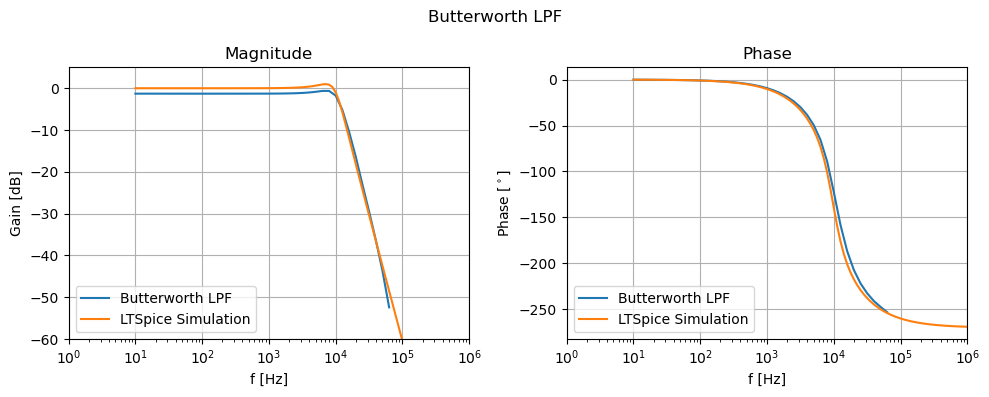

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
plot_bode("4_bode_bw3lpf.csv", fig, axes, name="Butterworth LPF")
plot_bode_spice("But_lpf.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0-360)
# plot_bode_spice("chevi_LPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0-360)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Butterworth LPF")
fig.tight_layout()

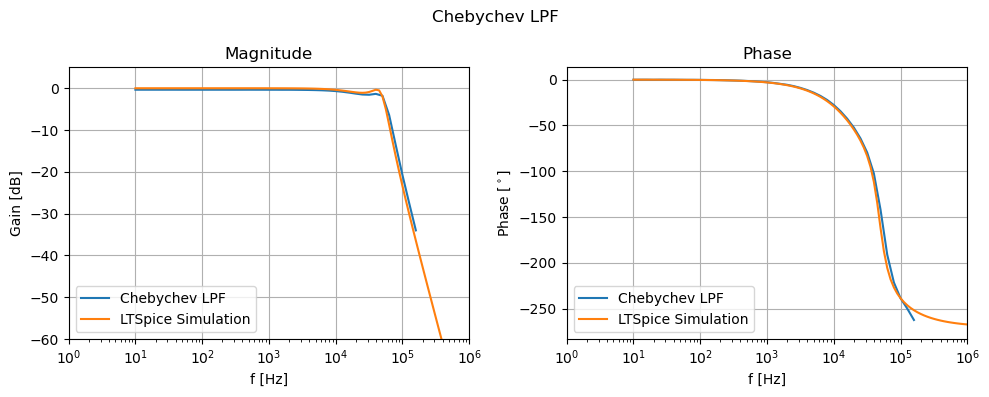

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_cheblpf_re.csv", fig, axes, name="Chebychev LPF", cutoff_db=-40)
plot_bode_spice("chevi_LPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0-360)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Chebychev LPF")
fig.tight_layout()

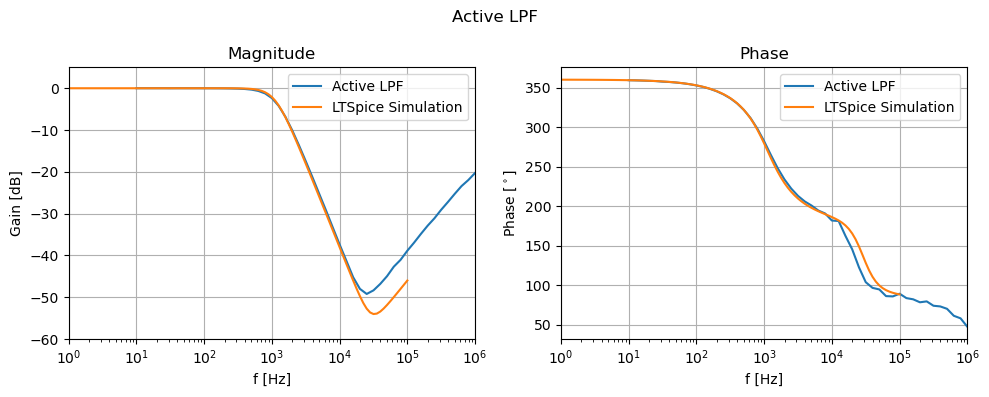

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("5_bode_activelpf.csv", fig, axes, name="Active LPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("active_lpf.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Active LPF")
fig.tight_layout()

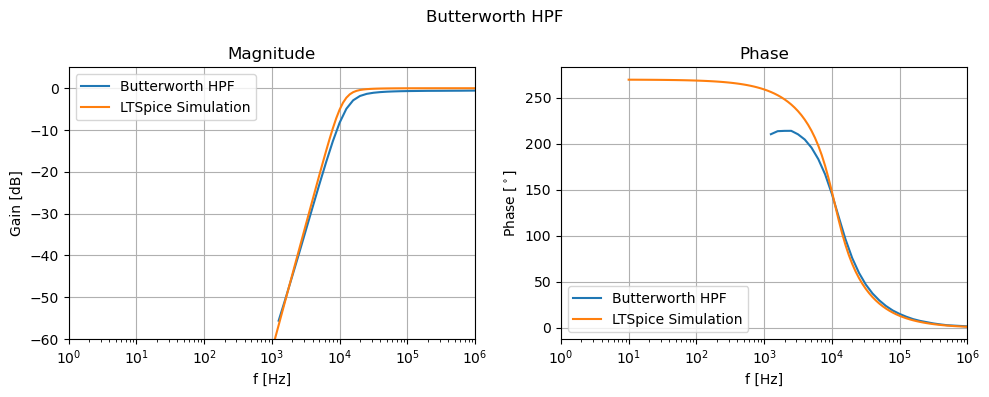

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_bw3hpf.csv", fig, axes, name="Butterworth HPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("But_HPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Butterworth HPF")
fig.tight_layout()

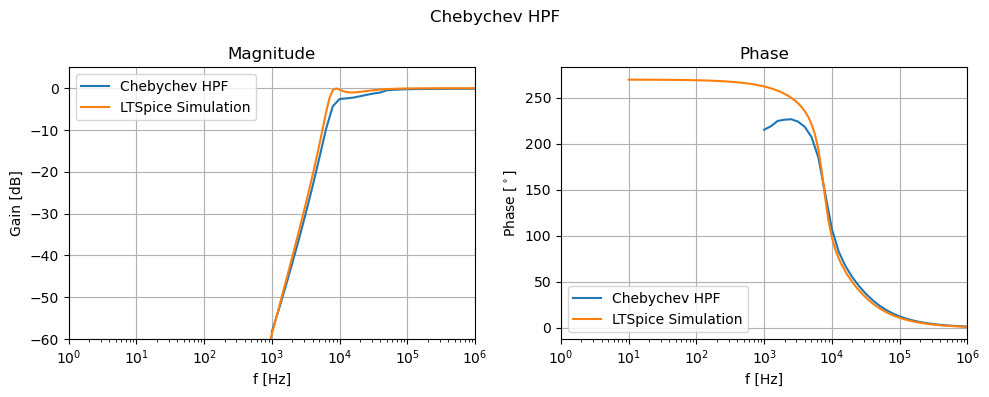

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_chebhpf.csv", fig, axes, name="Chebychev HPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("chevi_HPF.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Chebychev HPF")
fig.tight_layout()

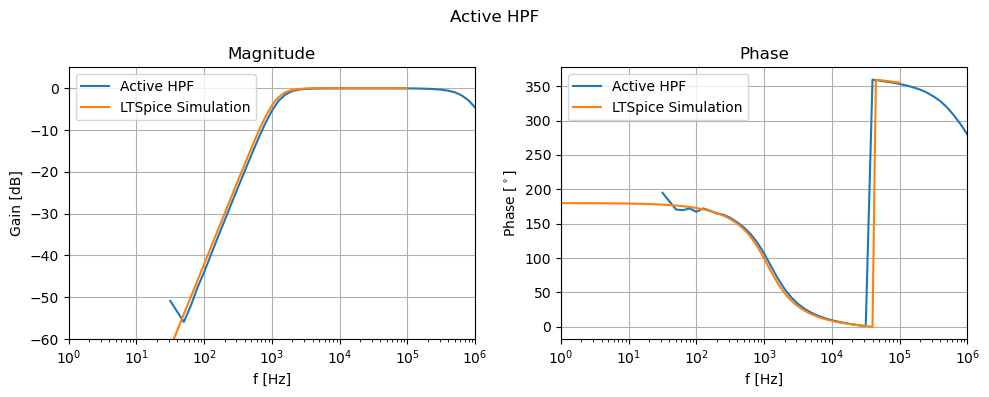

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("5_bode_activehpf.csv", fig, axes, name="Active HPF", cutoff_db=-60, argshift=lambda x: (x+360)%360.0)
plot_bode_spice("active_hpf.txt", axes, name="LTSpice Simulation", argshift=lambda x: (x+360)%360.0)
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
axstgs_filters[0].apply_axes(axes[0])
axstgs_filters[1].apply_axes(axes[1])
fig.suptitle("Active HPF")
fig.tight_layout()

/tmp/ipykernel_2068/2003998435.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

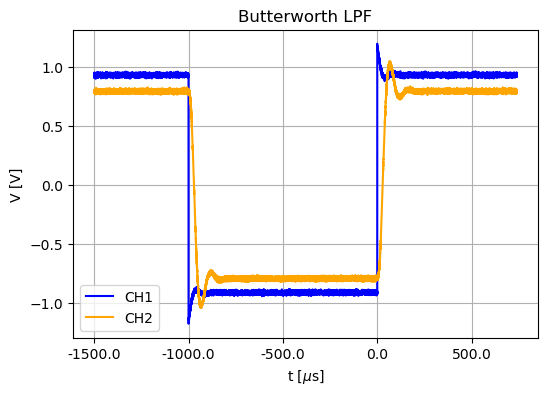

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_bwlpf_zoom.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Butterworth LPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_2068/583297909.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

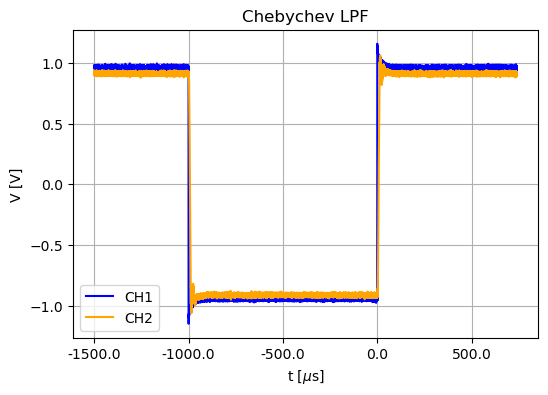

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_cheblpf_re.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Chebychev LPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_2068/477103146.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

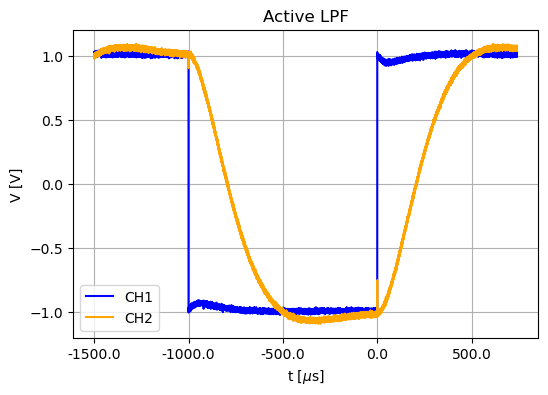

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("5_osc_activelpf.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Active LPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_2068/830563790.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

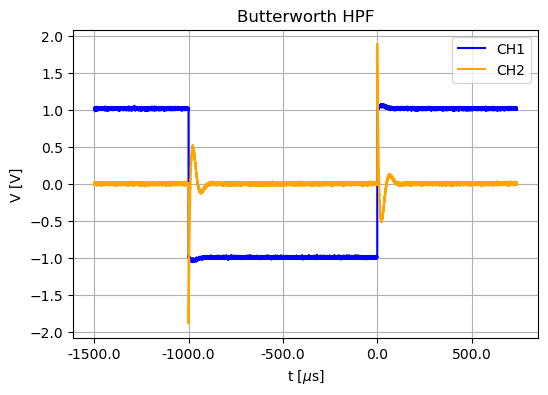

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_bwhpf_zoom.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Butterworth HPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_2068/3524985905.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

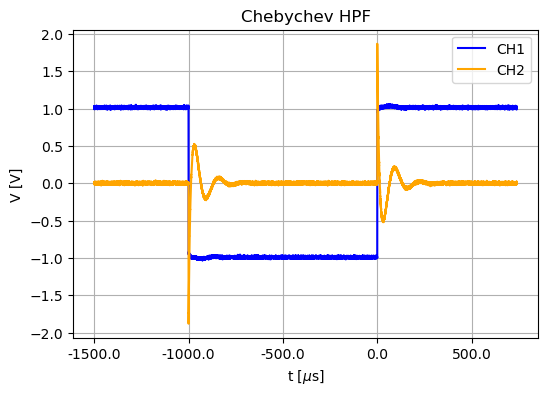

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("4_osc_chebhpf_zoom.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Chebychev HPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")

/tmp/ipykernel_2068/2782718945.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(np.round(axes.get_xticks()*1e6))


Text(0.5, 0, 't [$\\mu$s]')

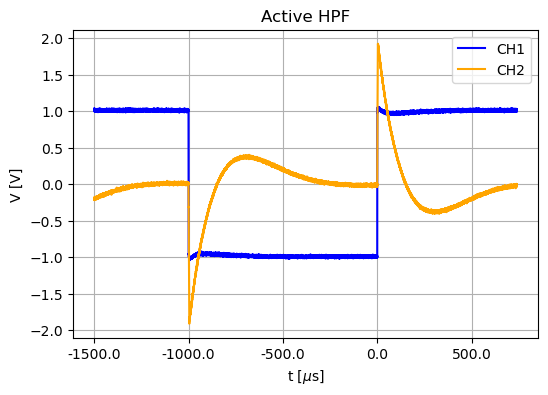

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plot_osc("5_osc_activehpf.csv", axes)
axstgs_osc.apply_axes(axes)
axes.set_title("Active HPF")
axes.set_xticklabels(np.round(axes.get_xticks()*1e6))
axes.set_xlabel("t [$\mu$s]")